In [13]:
import os
from email.parser import Parser
import numpy as np
import pandas as pd
import re
import nltk

from bs4 import BeautifulSoup

# from sklearn import metrics, manifold
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import sequence

from transformers import BertTokenizer

# 1. Data Organizing

In [2]:
def extract_content(message):
    'a helper function to read the body of an email'
    parts=[]
    for part in message.walk():
        if part.get_content_type()=='text/plain':
            parts.append(part.get_payload())
    return ''.join(parts)

In [3]:
if not os.path.exists('email_df.csv'):

    # read the subject and content into a dataframe

    email_df=pd.DataFrame({'Subject':[],'Content':[]})

    senders=os.listdir('maildir')
    senders.sort()

    print('Now working on sender:')
    print('-'*30)
    for sender in senders:
        print(sender)

        sender_directories=os.path.join('maildir/',sender)

        for (emails_path,_,emails) in os.walk(sender_directories):

            for email_i in emails:
                email_path=os.path.join(emails_path,email_i)
                with open(email_path, encoding = "latin1") as email_now:
                    data=email_now.read()
                    email=Parser().parsestr(data)
                    email_df.loc[len(email_df),:]=np.array(
                        [email['Subject'],
                         extract_content(email)])

    email_df.to_csv('email_df.csv')

else:
    
    email_df=pd.read_csv('email_df.csv')
    

Now working on sender:
------------------------------
allen-p
arnold-j
arora-h
badeer-r
bailey-s
bass-e
baughman-d
beck-s
benson-r
blair-l
brawner-s
buy-r
campbell-l
carson-m
cash-m
causholli-m
corman-s
crandell-s
cuilla-m
dasovich-j
davis-d
dean-c
delainey-d
derrick-j
dickson-s
donoho-l
donohoe-t
dorland-c
ermis-f
farmer-d
fischer-m
forney-j
fossum-d
gang-l
gay-r
geaccone-t
germany-c
gilbertsmith-d
giron-d
griffith-j
grigsby-m
guzman-m
haedicke-m
hain-m
harris-s
hayslett-r
heard-m
hendrickson-s
hernandez-j
hodge-j
holst-k
horton-s
hyatt-k
hyvl-d
jones-t
kaminski-v
kean-s
keavey-p
keiser-k
king-j
kitchen-l
kuykendall-t
lavorato-j
lay-k
lenhart-m
lewis-a
linder-e
lokay-m
lokey-t
love-p
lucci-p
maggi-m
mann-k
martin-t
may-l
mccarty-d
mcconnell-m
mckay-b
mckay-j
mclaughlin-e
merriss-s
meyers-a
mims-thurston-p
motley-m
neal-s
nemec-g
panus-s
parks-j
pereira-s
perlingiere-d
phanis-s
pimenov-v
platter-p
presto-k
quenet-j
quigley-d
rapp-b
reitmeyer-j
richey-c
ring-a
ring-r
rodrique-r
rogers-b

In [4]:
# see what the content of the emails dataframe looks like
email_df.iloc[0:10]['Content']

0    ---------------------- Forwarded by Phillip K ...
1    ---------------------- Forwarded by Phillip K ...
2    Dave, \n\n Here are the names of the west desk...
3             Paula,\n\n 35 million is fine\n\nPhillip
4    ---------------------- Forwarded by Phillip K ...
5    ---------------------- Forwarded by Phillip K ...
6    ---------------------- Forwarded by Phillip K ...
7    Brenda,\n\nPlease use the second check as the ...
8    I think Fletch has a good CPA.  I am still doi...
9    Brenda,\n\n Please use the second check as my ...
Name: Content, dtype: object

In [5]:
print('Number of total emails: ',len(email_df))

Number of total emails:  517401


### Let's see a few examples of the emails:

In [10]:
email_df['Content'][30]

'__________________________________\nMARKET ALERT\nfrom The Wall Street Journal\n\n\nDecember 13, 2000\n\nThe Nasdaq composite dropped 108.31, or 3.7%, to 2823.46 Wednesday as\ninvestors turned their attention to earnings warnings. The market couldn\'t\nsustain initial enthusiasm that the election drama was nearing a close, but\nthe Dow industrials finished up 26.17 at 10794.44.\n\nFOR MORE INFORMATION, see:\nhttp://interactive.wsj.com/pages/money.htm\nTO CHECK YOUR PORTFOLIO, see:\nhttp://interactive.wsj.com/pj/PortfolioDisplay.cgi\n\n\n__________________________________\nADVERTISEMENT\n\nVisit CareerJournal.com, The Wall Street\nJournal\'s executive career site. Read 2,000+\narticles on job hunting and career management,\nplus search 30,000+ high-level jobs. For today\'s\nfeatures and job listings, click to:\n\nhttp://careerjournal.com\n\n__________________________________\nLOOKING FOR THE PERFECT HOLIDAY GIFT?\n\nGive a subscription to WSJ.com.\n\nVisit http://interactive.wsj.com/gi

In [11]:
email_df['Content'][7256]

'Saudis Set to Select Firms for Gas Projects\nThe Wall Street Journal, 05/14/01\n\nCheney task force seeks input from interest groups\nAssociated Press Newswires, 05/14/01\n\nCOMPANIES & FINANCE UK: Independents drill deep to strike rich seams: A new \ngeneration of smaller oil companies is emerging; a group that has discovered \nhow to be competitive, writes David Buchan: Financial Times; May 14, 2001\n\nBush energy team covers all the bases\nChicago Tribune, 05/14/01\n\nQATAR: UAE\'s Dolphin may seek new partners if Enron exits.\nReuters English News Service, 05/14/01\n\nUAE: UPDATE 1-Saudi expected to name gas race winners on Tuesday.\nReuters English News Service, 05/14/01\n\nSaudi Oil Council To Meet Tue On Gas Projects -Sources\nDow Jones Energy Service, 05/14/01\n\nRFID chip will help speed up business\nThe New Straits Times, 05/14/01\n\nIndia: Godbole panel report may suggest MSEB bifurcation\nBusiness Line, 05/14/01\n\nTertiary will be primary\nBusiness Standard, 05/14/01\nAce

In [12]:
email_df['Content'][122456]

"\n\n -----Original Message-----\nFrom: \tJackson, Karl  \nSent:\tThursday, October 18, 2001 6:16 PM\nTo:\tGeaccone, Tracy\nSubject:\tAllocations\n\nI'm getting back to something, I left  you a message last week.  When Barney presented the ETS budget for the pipeline operations, he included amounts allocated from ETS for IT ($170k) and Accounting ($59k).  You left me a phone mail  message regarding the IT charge and suggested that I contact Caroline Barnes (which I did today).  Both of these appear to be new charges for 2002 and we'd like to get information on what they relate to.  Can you shed some light on the Accounting charge?\n\nThanks\nKarl"

In [13]:
email_df['Content'][172456]

'Stan -\nAttached is a straw-man outlining a possible structure and principles.  Jim\nTempleton made a few changes and may have some others today.  Please let me\nknow if you have any changes to it -- particularly if you think the tone is\npresumptuous.  Thanks,  Rae\n\n - structure.PDF'

# 2. Data_preprocessing

In [8]:
# a helper function to remove any html code in the text
def remove_html(txt):
    soup=BeautifulSoup(txt, "html.parser")
    return ' '.join(soup.stripped_strings)

# define a function to clean, tokenize, stemming and lemmatise the text
def preprocess_text(text,stemm=False, lemm=True, basic_clean=0):
    
    # if basic_clean=1,
    # specials symbols will be retained and
    # original length of the email will be kept
    
    if text != text: # check if it is NaN
        return ''
    
    # 1. cleaning the text
    # ----------------
    
    # remove any html code present in the email
    clean_text=remove_html(text)
    
    # remove [IMAGE]
    clean_text=re.sub(r'\[IMAGE\]','',clean_text)
    # remove aaaaaaaaaaaaaaa , which was found to occur frequently in emails
    clean_text=re.sub(r'\w*aaaaaa\w*','',clean_text)
    
    # remove <any_string> remaining
    clean_text=re.sub(r"<.*>", "", clean_text)

    # remove unicode whitespace characters like \n, \t with white space
    clean_text=re.sub('\s',' ',clean_text.lower())

    # remove date
    clean_text=re.sub('^(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4})$','',clean_text)
    clean_text=re.sub(r'\bmon\b|\btue\b|\bwed\b|\bthu\b|\bthur\b|\bfri\b|\bsat\b|\bsun\b','',clean_text)
    clean_text=re.sub(r'\bmonday\b|\btuesday\b|\bwednesday\b|\bthursday\b|\bfriday\b|\bsaturday\b|\bsunday\b','',clean_text)
    clean_text=re.sub('\d+th|\d+st|\d+nd','',clean_text)
    clean_text=re.sub(r'\bjan\b|\bfeb\b|\bmar\b|\bapr\b|\bmay\b|\bjun\b|\bjul\b|\baug\b|\bsep\b|\boct\b|\bnov\b|\bdec\b','',clean_text)
    clean_text=re.sub(r'\bjanuary\b|\bfeburary\b|\bmarch\b|\bapril\b|\bmay\b|\bjune\b|\bjuly\b|\baugust\b|\bseptember\b|\boctober\b|\bnovember\b|\bdecember\b','',clean_text)

    # remove webiste link
    clean_text=re.sub(r'https?:\/\/\S*','',clean_text)

    # remove emails 
#     clean_text=re.sub('[0-9a-z\.\-_]*@|\.com|\.net','',clean_text) # if wanna keep the domain name
    clean_text=re.sub('\S*@\S*\s?','',clean_text) 

    # replace _ , \. and \, with white space
    clean_text=re.sub('[_\.\,]',' ',clean_text)
    
    if not basic_clean:
        # remove other special symbols
        clean_text=re.sub('[^\w\s]',' ',clean_text)

    # remove time
    clean_text=re.sub(r'\b\d+ (a|p)\.?m\.?\b|\bpst\b|\bmst\b|\bcst\b|\best\b|\bpt\b|\bmt\b|\bct\b|\bet\b',
                      '',clean_text)

    # remove all the string having only numbers, including the phone numbers
#     clean_text=re.sub(r'\b \d+ \b|\b\d+ | \d+\b|^\d+\s|\s\d+\s|\s\d+$', ' ',clean_text)

    # remove any word containing numbers
    clean_text=re.sub('\w*\d\w*',' ',clean_text)

    # remove single letter in a sentence
    clean_text=re.sub(r'(?<=\b)\w{1}(?=\b)', ' ',clean_text)
    
    if not basic_clean:
        # remove every content before the last 'subject'
        # since if it were a series of replied/ forwarded email, the last email
        # in the series should content enough info to determine if it is business related
        tmp_clean=clean_text.split('subject')
        if len(tmp_clean)==1 and not tmp_clean[-1]:
            clean_text=tmp_clean[-1]
        else:
            clean_text=(tmp_clean[-1] if tmp_clean[-1] else tmp_clean[-2]) # in case it is empty after the last subject

    # clear extra whitespace
    clean_text=re.sub(' +', ' ',clean_text)

    clean_text=clean_text.strip()
    
    
    # 2. tokenization (convert the text into list)
    # ----------------
    clean_text=clean_text.split()
    
    # 3. remove stopwords (e.g. an, a, the, about etc.)
    # ----------------
    list_stopwords=nltk.corpus.stopwords.words('english')
    clean_text=[word for word in clean_text if word not in list_stopwords]
    
    # 4. stemming (remove -ing, -ly etc.)
    # ----------------
    if stemm:
        ps=nltk.stem.porter.PorterStemmer()
        clean_text=[ps.stem(word) for word in clean_text]
    
    # 5. lemmatisation (reduce the words to root words)
    # ----------------
    if lemm:
        lem=nltk.stem.wordnet.WordNetLemmatizer()
        clean_text=[lem.lemmatize(word) for word in clean_text]
    
    # 6. convert back to string for output
    # ----------------
    text=' '.join(clean_text)
    
    return text
    

In [11]:
#process the text

process_the_text=True

if process_the_text:
    
    # apply only basic clean to the Subject+Content
    # to keep the symbols and original length of the emails
    # for labelling the ground true by the 
    # glossary used in oil and gas trading
    email_df['subject_basic_clean']=email_df['Subject'].apply(
        lambda x: preprocess_text(x, stemm=False,lemm=True,
                                  basic_clean=1))
    email_df['text_basic_clean']=email_df['Content'].apply(
        lambda x: preprocess_text(x, stemm=False,lemm=True,
                                  basic_clean=1))
    
    email_df['subject_clean']=email_df['Subject'].apply(
        lambda x: preprocess_text(x, stemm=False,lemm=True))
    email_df['text_clean']=email_df['Content'].apply(
        lambda x: preprocess_text(x, stemm=False,lemm=True))
    
    # renew the saved version of email_df or not
    renew_email_df=True
    if renew_email_df:
        email_df.to_csv('email_df.csv')

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://planet.enron.com/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://hotcs.enron.com/fundyplasma/site/Financial.jsp" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://ecthou-webcl1.nt.ect.enron.com/gas/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautifu

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.siliconvalley.com/docs/news/svtop/revis082801.htm" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://energycommerce.house.gov/107/pubs/andersenmemos.pdf" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://abcnews.go.com/sections/wnt/DailyNews/enron_shred020121.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to g

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.sportingnews.com/nfl/support/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://cbs.sportsline.com/u/ce/feature/0,1518,2459991_54,00.html

http://cnnsi.com/basketball/nba/2000/nba_draft/news/2000/05/25/mock_draft1/
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.theonion.com/onion3618/kid_rock_starves.html" looks like a URL. Beautiful Soup is not an HTTP client. You s

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.telski.com/tandp/extras/photo_of_day/index.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.dovewinds.com/dubya/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://espn.go.com/ncf/columns/feldman/822932.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.phazer.org/samuel.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.chilliman.com/beer_labels_frame.htm" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.oanda.com/converter/cc_quotes" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautifu

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://ca1.tradewave.com/tradeauth/userReg/SPP/EPMI" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.cedarpoint.com/public/inside_park/rides/thrill/millennium/photo_gallery/mf_photo_9d.cfm" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.geocities.com/fobionaire/Fobionair.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://westpower.enron.com/maria/reportdiffs.asp" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.fonix.com/downloads/ttsdemo.php" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://cdec.water.ca.gov/cgi-progs/iodir/DLYSWEQ.20010210" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and fe

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.greekbible.com" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.bible.com/bible_read.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.familyfeud.tv/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.nysb.uscourts.gov/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.pge-texas.com/www/gtt.nsf/htmlmedia/operations.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://abacustech.net/pictures/12-10_Christmas_Tree_Farm" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and fe

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.initiativesforchildren.org/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://homeadvisor.msn.com/pickaplace/comparecities.asp?TS=UT&selFS=TX&selTS=UT&selFC=0&selTC=0&PFC=Houston&PTC=San%20Francisco&EarningFromCity=50000&PFS=TX&PTS=CA" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "https://hrglobal.enron.com/index.asp" looks like a URL. Beautiful Soup is not an HTTP client. You s

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://messages.yahoo.com/bbs?.mm=FN&action=m&board=4687034&tid=ntap&sid=46870
34&mid=40327" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://eastpower.dev.corp.enron.com/portal/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.geocities.com/Colosseum/Track/2855/col1.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests 

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.france3.fr/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.math.ethz.ch/finance/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://dir.hotbot.lycos.com/Society/People/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.war

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://theeconomist.s.maildart.net/link_34012_6617738_3_79868880_16706295_1_68" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.insectdissection.com/badges/fullbadges.wav" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.doc.ic.ac.uk/~srueger/pr-suprema-1999/Justin-Hayward/main_page.html#newcombs_observations
" looks like a URL. Beautiful Soup is not an HTTP client. You should

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.washingtonpost.com/wp-dyn/articles/A22448-2001Dec24.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "https://ecthou-webcl1.ect.enron.com/gas/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://enaresearch.corp.enron.com/research/framework/default.asp" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the documen

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.winstar.com/career/content_current_sales.asp#career506" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://moneycentral.msn.com/articles/retire/basics/4739.asp?Special=special?sp
ecial=msn" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.imagestation.com/album/?id=4293626105&code=518755&mode=invite" looks like a URL. Beautiful Soup is not an HTTP client. You should probab

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.rothers.com/rng/search_results.asp?mscssid=R14S8CXSPE0T8KU32WCA5W9XS8QD8C87" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.houstonpress.com/products/399/index.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.ets.oatiinc.com/cgi-bin/webplus.dll?script=%2Fets%2Fets-main.wml" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTT

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://story.news.yahoo.com/news?tmpl=story&u=/020624/168/1qq1k.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://tonto.eia.doe.gov/whatsnew/newwhatsnew.cfm" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://mach.usno.navy.mil/cgi-bin/aa_moonill.pl" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behin

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.fortune.com/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.tlksolutions.com/family/multimedia.asp" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.1400smith.com" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.gmu.edu/departments/economics/wew/01/energy.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.latimes.com/news/local/la-000082983oct18.story?coll=la%2Dheadlines%2Dcalifornia" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.enron.com/corp/pressroom/faq.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like reque

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.nrc.gov/OPA/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.gotlaughs.com/funpages/bin2.cfm" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.dslreports.com/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.forsalebyowner.com/cgi-bin/searchHome.cgi?iHomeID=3620274&iPhotoNum
=1" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.chron.com/cs/CDA/story.hts/business/1133446" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.clubmonkey.com/Houston/LeagueInfo.htm#Wiffle" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests

C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.ncdc.noaa.gov/onlineprod/drought/xmgr.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "https://hrglobal.enron.com/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\yc_ya\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.corptraining.com/index.cfm?company=enron" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document

In [12]:
# see how the processed text is like
email_df.head(10)

,Subject,Content,subject_basic_clean,text_basic_clean,subject_clean,text_clean
0,Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,consolidated positions: issue & list,---------------------- forwarded phillip allen...,consolidated position issue list,consolidated position issue list initial set m...
1,Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,consolidated positions: issue & list,---------------------- forwarded phillip allen...,consolidated position issue list,consolidated position issue list initial set m...
2,,"Dave, \n\n Here are the names of the west desk...",,dave name west desk member category originatio...,,dave name west desk member category originatio...
3,Re: 2001 Margin Plan,"Paula,\n\n 35 million is fine\n\nPhillip",re: margin plan,paula million fine phillip,margin plan,paula million fine phillip
4,"Var, Reporting and Resources Meeting",---------------------- Forwarded by Phillip K ...,var reporting resource meeting,---------------------- forwarded phillip allen...,var reporting resource meeting,var reporting resource meeting please plan att...
5,Westgate,---------------------- Forwarded by Phillip K ...,westgate,---------------------- forwarded phillip allen...,westgate,westgate westgate enclosed demographic westgat...
6,Meeting re: Storage Strategies in the West,---------------------- Forwarded by Phillip K ...,meeting re: storage strategy west,---------------------- forwarded phillip allen...,meeting storage strategy west,meeting storage strategy west meeting regardin...
7,,"Brenda,\n\nPlease use the second check as the ...",,brenda please use second check payment already...,,brenda please use second check payment already...
8,Re: Not business related..,I think Fletch has a good CPA. I am still doi...,re: business related,think fletch good cpa still,business related,think fletch good cpa still
9,Re: Original Sept check/closing,"Brenda,\n\n Please use the second check as my ...",re: original sept check/closing,brenda please use second check payment copy or...,original sept check closing,brenda please use second check payment copy or...


In [13]:
# append the cleaned 'Subject' to the cleaned 'Content'
# because some emails have quite empty content 
# and the keyword info is in the subject

def merge_subject_content(subject_text,content_text):

    #if content_text and subject_text are nan
    if subject_text != subject_text and content_text != content_text: 
        return ''
    elif subject_text != subject_text: #if subject_text is nan
        return content_text.lower()
    elif content_text != content_text: #if content_text is nan
        return subject_text.lower()
    elif subject_text in content_text:
        return content_text.lower()
    else: 
        return (subject_text+' '+content_text).lower()

email_df['subject_text_basic_clean']=email_df.apply(lambda x: merge_subject_content(
    x['subject_basic_clean'],x['text_basic_clean']),axis=1)
    
email_df['subject_text_clean']=email_df.apply(lambda x: merge_subject_content(
    x['subject_clean'],x['text_clean']),axis=1)

In [14]:
# see how the resultant email_df is like
email_df.head(10)

,Subject,Content,subject_basic_clean,text_basic_clean,subject_clean,text_clean,subject_text_basic_clean,subject_text_clean
0,Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,consolidated positions: issue & list,---------------------- forwarded phillip allen...,consolidated position issue list,consolidated position issue list initial set m...,---------------------- forwarded phillip allen...,consolidated position issue list initial set m...
1,Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,consolidated positions: issue & list,---------------------- forwarded phillip allen...,consolidated position issue list,consolidated position issue list initial set m...,---------------------- forwarded phillip allen...,consolidated position issue list initial set m...
2,,"Dave, \n\n Here are the names of the west desk...",,dave name west desk member category originatio...,,dave name west desk member category originatio...,dave name west desk member category originatio...,dave name west desk member category originatio...
3,Re: 2001 Margin Plan,"Paula,\n\n 35 million is fine\n\nPhillip",re: margin plan,paula million fine phillip,margin plan,paula million fine phillip,re: margin plan paula million fine phillip,margin plan paula million fine phillip
4,"Var, Reporting and Resources Meeting",---------------------- Forwarded by Phillip K ...,var reporting resource meeting,---------------------- forwarded phillip allen...,var reporting resource meeting,var reporting resource meeting please plan att...,---------------------- forwarded phillip allen...,var reporting resource meeting please plan att...
5,Westgate,---------------------- Forwarded by Phillip K ...,westgate,---------------------- forwarded phillip allen...,westgate,westgate westgate enclosed demographic westgat...,---------------------- forwarded phillip allen...,westgate westgate enclosed demographic westgat...
6,Meeting re: Storage Strategies in the West,---------------------- Forwarded by Phillip K ...,meeting re: storage strategy west,---------------------- forwarded phillip allen...,meeting storage strategy west,meeting storage strategy west meeting regardin...,---------------------- forwarded phillip allen...,meeting storage strategy west meeting regardin...
7,,"Brenda,\n\nPlease use the second check as the ...",,brenda please use second check payment already...,,brenda please use second check payment already...,brenda please use second check payment already...,brenda please use second check payment already...
8,Re: Not business related..,I think Fletch has a good CPA. I am still doi...,re: business related,think fletch good cpa still,business related,think fletch good cpa still,re: business related think fletch good cpa still,business related think fletch good cpa still
9,Re: Original Sept check/closing,"Brenda,\n\n Please use the second check as my ...",re: original sept check/closing,brenda please use second check payment copy or...,original sept check closing,brenda please use second check payment copy or...,re: original sept check/closing brenda please ...,original sept check closing brenda please use ...


# 3. Label the emails by Glossary as the ground true

In [15]:
# load the glossary from oil and gas trading 
glossary=np.load('glossary.npz')

keywords=[word.lower() for word in glossary['glossary']]

# gonna remove the keyword if the whole phase is just some stopwords 
# or common words (particularly those with too many acronyms)
# in the glossary
list_stopwords=nltk.corpus.stopwords.words('english')
more_common_words=['wow','well','load','ice', 'producer','future','im','log',]

# clean also the glossry in case there is stop word in it
# as well as so as to look for only the root words
keywords=[keyword for keyword in keywords if keyword not in list_stopwords+more_common_words]

keywords

['barrel',
 'toolpusher',
 'collar option',
 'rail tank car',
 'distillation',
 'thermal recovery',
 'c&f',
 'producing field',
 'e&p',
 'spa',
 'interruptible',
 'refiner',
 'in-situ combustion',
 'exercise price',
 'clean',
 'cswip',
 'dubai crude',
 'crine',
 'gas cycling',
 'bubble point',
 'extraction losses',
 'spud',
 'drillship',
 'emissions',
 'principal',
 'afe',
 'fob',
 'linear programme',
 'petroleum product',
 'unitisation',
 'sweet crude oil',
 'plateau level',
 'refinery output',
 '"fracing"',
 'petrochemical',
 'sour crude oil',
 'new york mercantile exchange',
 'ulcc',
 'eor',
 'equity petroleum',
 'ron /mon',
 'deregulated gas',
 'c3 h8',
 'roundtrip',
 'cif',
 'gross product worth',
 'gas cap',
 'equity capital',
 'packer',
 'formation fracturing',
 'residual oil',
 'cost',
 'royalty',
 'twelve current members',
 'cracking',
 'spark spread',
 'platform',
 'field',
 'reservoir drive',
 'whipstock',
 'production licence',
 'chicago mercantile exchange',
 'vapour recov

In [16]:
def label_grd_true(text,glossary,num_word_match):
    # if there are >= num_word_match in the text,
    # the text will be labelled to be relevant
    
    cnt=0
    
    for key_word in glossary:
        if bool(re.findall(r'(?<=\b)'+key_word+r'(?=\b)',text)):
            cnt+=1
            if cnt>=num_word_match:
                return 1
        
    return 0

In [17]:
num_email_sampled=10000

label_threshold=(email_df[:num_email_sampled]).apply(
    lambda x: label_grd_true(x['subject_text_clean'],keywords,num_word_match=1),axis=1)


In [18]:
sum(label_threshold)

3680

The ratio of relevant label/total emails is around the same ratio as that in hand labelling

In [19]:
#put the label to email_df
email_df['label']=email_df.apply(
        lambda x: label_grd_true(x['subject_text_basic_clean'],keywords,num_word_match=1),axis=1)


In [20]:
email_df.head(20)

,Subject,Content,subject_basic_clean,text_basic_clean,subject_clean,text_clean,subject_text_basic_clean,subject_text_clean,label
0,Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,consolidated positions: issue & list,---------------------- forwarded phillip allen...,consolidated position issue list,consolidated position issue list initial set m...,---------------------- forwarded phillip allen...,consolidated position issue list initial set m...,1
1,Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,consolidated positions: issue & list,---------------------- forwarded phillip allen...,consolidated position issue list,consolidated position issue list initial set m...,---------------------- forwarded phillip allen...,consolidated position issue list initial set m...,1
2,,"Dave, \n\n Here are the names of the west desk...",,dave name west desk member category originatio...,,dave name west desk member category originatio...,dave name west desk member category originatio...,dave name west desk member category originatio...,0
3,Re: 2001 Margin Plan,"Paula,\n\n 35 million is fine\n\nPhillip",re: margin plan,paula million fine phillip,margin plan,paula million fine phillip,re: margin plan paula million fine phillip,margin plan paula million fine phillip,1
4,"Var, Reporting and Resources Meeting",---------------------- Forwarded by Phillip K ...,var reporting resource meeting,---------------------- forwarded phillip allen...,var reporting resource meeting,var reporting resource meeting please plan att...,---------------------- forwarded phillip allen...,var reporting resource meeting please plan att...,0
5,Westgate,---------------------- Forwarded by Phillip K ...,westgate,---------------------- forwarded phillip allen...,westgate,westgate westgate enclosed demographic westgat...,---------------------- forwarded phillip allen...,westgate westgate enclosed demographic westgat...,1
6,Meeting re: Storage Strategies in the West,---------------------- Forwarded by Phillip K ...,meeting re: storage strategy west,---------------------- forwarded phillip allen...,meeting storage strategy west,meeting storage strategy west meeting regardin...,---------------------- forwarded phillip allen...,meeting storage strategy west meeting regardin...,0
7,,"Brenda,\n\nPlease use the second check as the ...",,brenda please use second check payment already...,,brenda please use second check payment already...,brenda please use second check payment already...,brenda please use second check payment already...,0
8,Re: Not business related..,I think Fletch has a good CPA. I am still doi...,re: business related,think fletch good cpa still,business related,think fletch good cpa still,re: business related think fletch good cpa still,business related think fletch good cpa still,0
9,Re: Original Sept check/closing,"Brenda,\n\n Please use the second check as my ...",re: original sept check/closing,brenda please use second check payment copy or...,original sept check closing,brenda please use second check payment copy or...,re: original sept check/closing brenda please ...,original sept check closing brenda please use ...,0


Taking a brief look on the sample texts, the labelling by glossary is actually not bad.

In [21]:
# save the labelled email_df
email_df.to_csv('email_df_labelled.csv',index=False)

In [22]:
# randomly select some emails to for training the model
# as well as testing
email_df_sample=email_df.sample(n=100000,random_state=2021)
data=email_df_sample[['subject_text_clean','label']].reset_index(drop=True)
data.rename(columns={'subject_text_clean':'text'},inplace=True)
data.head(20)

,text,label
0,follow rehab quick update follow previous mail...,0
1,happy valentine day thought get laugh outta on...,0
2,jeff reminder please add distribution list kno...,0
3,oh little man sits next nice,0
4,fw vitol enron isda vitol enron isda hi stepha...,0
5,fw draft ken lay point opening panel draft ken...,0
6,please note conference call today discus updat...,0
7,test streamer news datekelite datek elite toll...,1
8,home address request asked put together list h...,0
9,fw alj ruling shortening time repond os turn e...,0


In [23]:
data.to_csv('sampled_data.csv',index=False)

To get an aggregate understanding of the texts labelled as 'relevant' and 'irrelevant', we can construct word clouds for each of the group for the most frequent words in them.

In [14]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize as wt

data=pd.read_csv('sampled_data.csv')
#somehow pd.to_csv will save '' to be NaN
# need to remove those
data['text']=data.apply(
    lambda x: '' if x['text']!=x['text'] else x['text'],axis=1)

text_relevant=data[data.label==1]
text_irrelevant=data[data.label==0]

In [15]:
def get_words(txt,word_list):
    tok=wt(txt)
    rev_word=[ww for ww in tok]
    word_list+=rev_word
    return

In [16]:
word_list_relevant=[]
text_relevant.text.apply(get_words,args=(word_list_relevant,))
word_list_relevant_seen=' '.join(word_list_relevant)
wc_relevant=WordCloud(width=600,height=512).generate(
    word_list_relevant_seen)

word_list_irrelevant=[]
text_irrelevant.text.apply(get_words,args=(word_list_irrelevant,))
word_list_irrelevant_seen=' '.join(word_list_irrelevant)
wc_irrelevant=WordCloud(width=600,height=512).generate(
    word_list_irrelevant_seen)

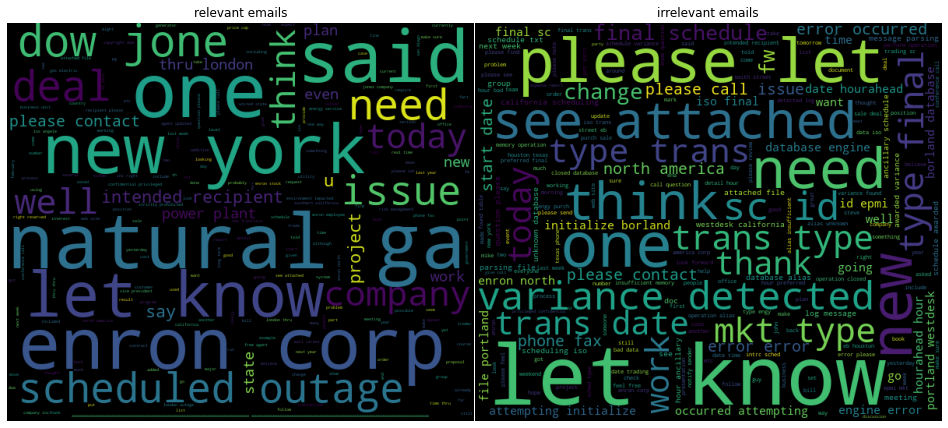

In [17]:
plt.figure(figsize=(13,7))

plt.subplot(1,2,1)
plt.imshow(wc_relevant)
plt.axis('off')
plt.title('relevant emails')

plt.subplot(1,2,2)
plt.imshow(wc_irrelevant)
plt.axis('off')
plt.title('irrelevant emails')

plt.tight_layout(pad=0.1)
plt.savefig('wordcloud.png')
plt.show()

While there are frequent words common in both 'relevant' and 'irrelevant' emails like 'Enron', 'new', etc, there are also different phases in the two groups. For example, there are more city names in the 'relevant' emails like 'new york' and 'London' and business related terms like 'scheduled outage' and 'natural gas'. Hopefully the sentiment analysis in the models can tell the differences from the common things using the 'tone' of the text.

# 4(I). Data preparation for BiLSTM/ GloVe embedding models

In [24]:
data=pd.read_csv('sampled_data.csv')
#somehow pd.to_csv will save '' to be NaN
# need to remove those
data['text']=data.apply(
    lambda x: '' if x['text']!=x['text'] else x['text'],axis=1)

In [25]:
# train/val/test split

train_ratio=0.7
val_ratio=0.15
# test_ratio=0.15

train=data[:int(train_ratio*len(data))].copy()
val=data[int(train_ratio*len(data)):int((train_ratio+val_ratio)*len(data))].copy()
val.reset_index(drop=True,inplace=True)
test=data[int((train_ratio+val_ratio)*len(data)):].copy()
test.reset_index(drop=True,inplace=True)

In [26]:
tokenizer=tfds.deprecated.text.Tokenizer()

voca_set=set()

for txt in train['text']:
    
    some_tokens=tokenizer.tokenize(txt)
    voca_set.update(some_tokens)

In [27]:
encoder=tfds.deprecated.text.TokenTextEncoder(
    voca_set,tokenizer=tokenizer)

def encode_pad_transform(sample):
    
    # input sample is a string
    encoded=encoder.encode(sample)
    # encode, padding, truncate
    pad=sequence.pad_sequences([encoded],padding='post',maxlen=150)
    return np.array(pad[0],dtype=np.int64)


In [28]:
# encode the data

train['encoded']=train.apply(
    lambda x: encode_pad_transform(x['text']),axis=1)

val['encoded']=val.apply(
    lambda x: encode_pad_transform(x['text']),axis=1)

test['encoded']=test.apply(
    lambda x: encode_pad_transform(x['text']),axis=1)

# convert to tensorflow tensor for training

train_text=tf.convert_to_tensor(list(train['encoded']), dtype=tf.int64)
train_label=tf.convert_to_tensor(list(train['label']), dtype=tf.int64)

val_text=tf.convert_to_tensor(list(val['encoded']), dtype=tf.int64)
val_label=tf.convert_to_tensor(list(val['label']), dtype=tf.int64)

test_text=tf.convert_to_tensor(list(test['encoded']), dtype=tf.int64)
test_label=tf.convert_to_tensor(list(test['label']), dtype=tf.int64)


In [29]:
np.savez('data_prep',
         train_text=train_text,
         train_label=train_label,
         val_text=val_text,
         val_label=val_label,
         test_text=test_text,
         test_label=test_label,
         voca_set=voca_set
        )

# 4(II). Data preparation for Bert

In [2]:
data=pd.read_csv('sampled_data.csv')
#somehow pd.to_csv will save '' to be NaN
# need to remove those
data['text']=data.apply(
    lambda x: '' if x['text']!=x['text'] else x['text'],axis=1)


In [3]:
# train/test split

train_ratio=0.7
val_ratio=0.15
# test_ratio=0.15

train=data[:int(train_ratio*len(data))]
val=data[int(train_ratio*len(data)):int((train_ratio+val_ratio)*len(data))]
val.reset_index(drop=True,inplace=True)
test=data[int((train_ratio+val_ratio)*len(data)):]
test.reset_index(drop=True,inplace=True)

In [4]:
# will use the base BERT model for uncased english for classification

tokenizer=BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True,
    max_length=512,
    add_special_tokens=True,
    pad_to_max_length=True
)

# a helper function to perform the encoding of the inputs for all of the emails
def bert_encoder(email):
    encoded=tokenizer.encode_plus(email, add_special_tokens=True,
                                  truncation=True, padding='max_length',
                                  return_attention_mask=True,
                                  return_token_type_ids=True)
    return [encoded['input_ids'], encoded['token_type_ids'], encoded['attention_mask']]

train_text=np.array(list(train.apply(lambda x: bert_encoder(x['text']),axis=1)))
val_text=np.array(list(val.apply(lambda x: bert_encoder(x['text']),axis=1)))
test_text=np.array(list(test.apply(lambda x: bert_encoder(x['text']),axis=1)))

# convert labels to the categorical values

train_label=tf.keras.utils.to_categorical(np.array(train['label']),
                                          num_classes=2)
val_label=tf.keras.utils.to_categorical(np.array(val['label']),
                                        num_classes=2)
test_label=tf.keras.utils.to_categorical(np.array(test['label']),
                                         num_classes=2)

In [5]:
# wrangle the inputs into three input dictionaries in tf.DataSet

train_reviews,train_segments,train_masks=np.split(train_text,3,axis=1)
val_reviews,val_segments,val_masks=np.split(val_text,3,axis=1)
test_reviews,test_segments,test_masks=np.split(test_text,3,axis=1)

train_reviews,train_segments,train_masks=train_reviews.squeeze(),train_segments.squeeze(),train_masks.squeeze()
val_reviews,val_segments,val_masks=val_reviews.squeeze(),val_segments.squeeze(),val_masks.squeeze()
test_reviews,test_segments,test_masks=test_reviews.squeeze(),test_segments.squeeze(),test_masks.squeeze()


In [6]:
np.savez('data_prep_bert',
         train_reviews=train_reviews,
         train_segments=train_segments,
         train_masks=train_masks,
         train_label=train_label,
         val_reviews=val_reviews,
         val_segments=val_segments,
         val_masks=val_masks,
         val_label=val_label,
         test_reviews=test_reviews,
         test_segments=test_segments,
         test_masks=test_masks,
         test_label=test_label)